# CREDIT CARD FRAUD DETECTION
##### ITCS 6112 SOFTWARE SYSTEM DESIGN AND IMPLEMENTATION

### Introduction

### Data
The dataset which we used from Kaggle contains transaction made in two days in September 2013 by European cardholders. Out of 284,807 records 492 were frauds. This is very unbalanced dataset. The dataset contains only numerical input variables which are result of a PCA transformation. 

There are total 31 columns in the dataset out of first 28 columns entitled as V1 to V28 are called Features except first column. The first column Time describes the seconds elapsed between each transaction and first transaction in dataset. The second last column Amount is the transacted amount and the last column which is Class has value 1 in case of fraud and 0 otherwise.


The dataset was originally collected and analyzed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.


### Source of the Data 
The data is taken from : https://www.kaggle.com/agpickersgill/credit-card-fraud-detection/data

### Get the necessary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import stats
import pickle
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


### Reading the Data

In [2]:
dataframe = pd.read_csv("creditcard.csv")

### Preprocessing

In [3]:
dataframe.shape

(284807, 31)

In [4]:
dataframe.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Normalize the data

The Amount column in the above description is in the different range compared to other columns, so let us scale the amount column also in the same range as others.

In [5]:
from sklearn.preprocessing import StandardScaler

dataframe = dataframe.drop(['Time'], axis=1)

dataframe['Amount'] = StandardScaler().fit_transform(dataframe['Amount'].values.reshape(-1, 1))
dataframe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Let's check if there are any missing values or null values in the data.

In [6]:
dataframe.isnull().values.any()

False

Great !! Looks like there are no missing values in the data.

In [7]:
X = dataframe.loc[:, dataframe.columns != 'Class']
Y = dataframe.loc[:, dataframe.columns == 'Class']

### Visualize the data

Let us see how both classes in the data is distributed.

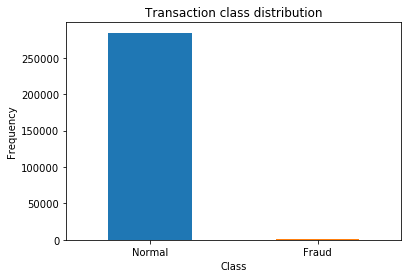

In [8]:
count_classes = pd.value_counts(dataframe['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

##### Clearly the data is totally unbalanced!!

As we can see from the above distribution graph, the data here is highly imbalanced.

There are several ways to approach this classification problem taking into consideration this unbalance.

- Collect more data? 
    - Nice strategy but not applicable in this case
- Resampling the dataset
    - Essentially this is a method that will process the data to have an approximate 50-50 ratio.
        - One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
        - Another is UNDER-sampling, which deletes instances from the over-represented class (better when we have lot's of data)
        
Since we have lot's of data here, we have chose **UNDER-SAMPLING** method.

In [9]:
# Number of data points in the minority class
number_records_fraud = len(dataframe[dataframe.Class == 1])
fraud_indices = np.array(dataframe[dataframe.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = dataframe[dataframe.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = dataframe.iloc[under_sample_indices,:]

X_us = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
Y_us = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


Let's check the distribution of the data after under-sampling.

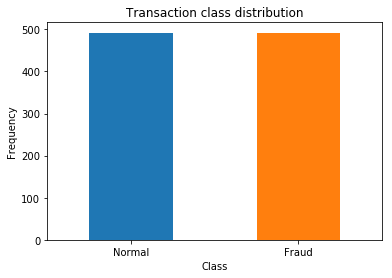

In [10]:
count_classes = pd.value_counts(Y_us['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

Now the data is in the 50-50 ratio.

Let's proceed with splitting our data into  train and test set.

In [11]:
# Whole dataset
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_us, X_test_us, Y_train_us, Y_test_us = train_test_split(X_us,Y_us,test_size = 0.3,random_state = 0)

print("")
print("Number transactions train dataset: ", len(X_train_us))
print("Number transactions test dataset: ", len(X_test_us))
print("Total number of transactions: ", len(X_train_us)+len(X_test_us))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


### Implementation of the Algorithms
$\newcommand{\xv}{\mathbf{x}}
$
Below is the code for the algorithms.Here we have implemented QDA (Quadratic Discriminant Analysis) and LDA (Linear Discriminant Analysis) and we have added some utilities methods to measure the performance of the algorithms.

__QDA Classifier__

$$
\delta_k(\xv) = -\frac{1}{2} \ln \vert \boldsymbol\Sigma_k \vert - \frac{1}{2} (\xv - \boldsymbol\mu_k)^\top \boldsymbol\Sigma_k^{-1} (\xv - \boldsymbol\mu_k) + \ln P(T = k). 
$$


 - Requires no alpha or a number for limited iterations. QDA only requires training data with input matrix (X) and the target value matrix (T)
 - No conversion is needed due to how QDA is capable of workibng on multiple classes
 - The mu, sigma, and prior are found by grouping data into a list of lists and running the calculations on each sublist.
    
__LDA Classifier__

$$
\delta_k(\xv) = \xv^\top \boldsymbol\Sigma^{-1} \boldsymbol\mu_+ -\frac{1}{2} \boldsymbol\mu_+^\top \boldsymbol\Sigma^{-1}\boldsymbol\mu_k + \ln P(T = k).
$$

 - Very similar to QDA classifier since it requires the same data matrices X and T, while also not requiring alpha and limited iterations
 - However, LDA is computationally cheaper due to not having to manage covariance matrix
 - Similarly to QDA, no conversion is required
    
   
__Evaluation Methods__

- **Accuracy** : It is the percentage of correct classifications.

$$
   \text{Accuracy} = \frac{\text{The number of correct classification}}{\text{The number of samples}}.
$$

- **Precision**: The accuracy of positive predictions. We can read this as *the ratio that my positive prediction is correct*.

$$
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

- **Recall** (Sensitivity or True Positive Rate): This measure give you how the model's prediction covers the positive class. 

$$
\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

- **Specificity** (True Negative Rate): Considering imblance or difference in class, we consider TNR as well. 

$$
\text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}
$$

- **F1 Score** : The harmonic mean of precision and recall. 

$$
\begin{align*}
F_1 &= \Bigg( \frac{\frac{1}{precision} + \frac{1}{recall}}{2} \Bigg)^{-1} \\
\\
    &= 2 \times \frac{precision \times recall}{precision + recall} \\
    \\
    &= \frac{TP}{TP + \frac{FN+FP}{2}}
\end{align*}
$$

- **MCC** (Matthews Correlation Coefficient): MCC uses all the counts in confusion matrix for the metric. 

$$
MCC = \frac{TP \times TN – FP \times FN}{\sqrt{(TP +FP) \times (TP + FN) \times (TN + FP) \times (TN + FN)}}
$$

- **ROC** : The ROC curve is another popular tool for binary classifications. The ROC curve plots the true positive rate (recall) vs the false positive rate (1 - specificity). 

- **AUC** : AUC measures the area to represent it with a numeric value by simply computing the area under the curve. AUC values are used also for various graphical measurement such as PR (Precision-Recall) curve.

- **Confusion Matrix** : Here, each row represents the predictions from model and column represents the actual classes.

| - | + 
 --|--|--
 - | True Negative (TN) | False Negative (FN)
 + | False Positive (FP) | True Positive (TP)



In [12]:
import numpy as np
from abc import ABC, abstractmethod

# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    

class Classifier(BaseModel):
    """
        Abstract class for classification 
        
        Attributes
        ==========
        meanX       ndarray
                    mean of inputs (from standardization)
        stdX        ndarray
                    standard deviation of inputs (standardization)
    """

    def __init__(self, ):
        self.meanX = None
        self.stdX = None

    def normalize(self, X):
        """ standardize the input X """
        
        if not isinstance(X, np.ndarray):
            X = np.asanyarray(X)

        self.meanX = np.mean(X, 0)
        self.stdX = np.std(X, 0)

        # TODO: Finish this normalization
        Xs = (X - self.meanX) / self.stdX
        return Xs

#     def normalize(self, X):
#         mu = X.mean()
#         std = X.std()
#         print("mu in norm",mu)
#         print("std in norm",std)
#         return (X-mu)/std

    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    abstractmethod
    def train(self, X, T):
        pass
    
    abstractmethod
    def use(self, X):
        pass 

In [13]:
from classifier import Classifier
import numpy as np

# QDA Classifier
class QDA(Classifier):
    
    def __init__(self):
        Classifier.__init__(self)
        self.mu = []
        self.Sigma = []
        self.prior = []
        
    def discriminant(self,X, mu, sigma, prior):
        sigma_inv = np.linalg.inv(sigma)
        diffv = X - mu
        return -0.5  * np.log(np.linalg.det(sigma)) \
                - 0.5 * np.sum(diffv @ sigma_inv * diffv, axis=1) \
                + np.log(prior)
                    
    def train(self, X, T):
        Xs = self.normalize(X)
        N = Xs.shape[0]
        for c in np.unique(T):
            c = T==c
            mu = np.mean(Xs[c,:],0)
            Sigma = np.cov(Xs[c].T)
            prior = np.sum(c) / N
            
            self.mu.append(mu)
            self.Sigma.append(Sigma)
            self.prior.append(prior)
            
    def use(self, X):
        Xs = (X-self.meanX)/self.stdX
        d = []
        for i in range(len(self.mu)):
            d.append(self.discriminant(Xs, self.mu[i], self.Sigma[i], self.prior[i]))
        return d

# LDA Classifier
class LDA(Classifier):
    
    def __init__(self):
        Classifier.__init__(self)
        self.mu = []
        self.Sigma = []
        self.prior = []        

    def discriminant(self, X, mu, sigma, prior):
        sigInv = np.linalg.inv(sigma)
        return X@sigInv@mu - .5*mu.T@sigInv@mu + np.log(prior)
                    
    def train(self, X, T):
        Xs = self.normalize(X)
        N = Xs.shape[0]
        self.Sigma = np.cov(Xs.T)
        for c in np.unique(T):
            c = T==c
            mu = np.mean(Xs[c,:],0)
            prior = np.sum(c) / N
            
            self.mu.append(mu)
            self.prior.append(prior)
        
            
    def use(self, X):
        Xs = (X-self.meanX)/self.stdX
        d = []
        for i in range(len(self.mu)):
            d.append(self.discriminant(Xs, self.mu[i], self.Sigma, self.prior[i]))
        return d


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def accuracy(Y,T):
    return np.sum(Y == T)/len(Y)

def precision(cfm):
    cfm = cfm.as_matrix()
    cfm = np.float64(cfm)
    return cfm[1, 1] / (cfm[1, 1] + cfm[1, 0])

def recall(cfm):
    cfm = cfm.as_matrix()
    cfm = np.float64(cfm)
    return cfm[1, 1] / (cfm[1, 1] + cfm[0,1])

def specificity(cfm):
    cfm = cfm.as_matrix()
    cfm = np.float64(cfm)
    return cfm[0,0]/(cfm[0,0]+cfm[1,0])

def f1Score(cfm):
    cfm = cfm.as_matrix()
    cfm = np.float64(cfm)
    return cfm[1,1] / cfm[1,1] + ((cfm[0,1]+cfm[1,0])/2)

# TN= cfm[0,0]
# FN= cfm[0,1]
# FP= cfm[1,0]
# TP= cfm[1,1]
def MCC(cfm):
    cfm = cfm.as_matrix()
    cfm = np.float64(cfm)
    return (cfm[1,1] * cfm[0,0]) - (cfm[1,0] * cfm[0,1]) \
    / np.sqrt((cfm[1,1] +cfm[1,0]) * (cfm[1,1] + cfm[0,1]) * (cfm[0,0] + cfm[1,0]) * (cfm[0,0] + cfm[0,1]))

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1.02])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

def roc(prob,Y):
    fpr, tpr, thresholds = roc_curve(Y, prob)
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    plt.show()
    
def roc_auc(prob,Y):
    return roc_auc_score(Y, prob)


def confusion_matrix(Y, T):
    """
        Y    nd.array
             predicted labels
        T    nd.array
             target labels
             
        @cfm DataFrame
             confusion matrix
    """
    
    if len(Y) != len(T):
        raise ValueError("Wrong prediction and target length!")
    
    classes = np.unique(T)
    n_classes = len(classes)
    
    cfm = pd.DataFrame(np.zeros((n_classes, n_classes)), index=classes, columns=classes, dtype=int)
    
    Tidx = [T == c for c in classes]
    for c in classes:
        pred_idx = Y == c
        cfm.loc[c, :] = [np.sum(np.logical_and(pred_idx, tidx)) for tidx in Tidx]
    
    return cfm

def plotClassifedResult(Y,T):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(T, 'o', color='b', label='Real',linewidth=5) 
    ax.plot(Y, '.', color='r', label='Predicted')
    ax.set_xlabel('Index')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()
                                                     
def allStats(Y,T):
    cfm = confusion_matrix(Y,T)
    display(cfm)
    display(pd.DataFrame([['TN','FN'],['FP','TP']],index=["-","+"],columns=["-","+"]))
    stats = [accuracy(Y,T),precision(cfm),recall(cfm),specificity(cfm),f1Score(cfm),MCC(cfm),roc_auc(Y,T)]
    display(pd.DataFrame(stats,index=["Accuracy","Precision","Recall","Specificity","F1 Score","MCC","ROC_AUC"],columns=["Stats"]))
    plotClassifedResult(Y,T)
    roc(Y,T)
    return stats 

def compStats(Y,T):
    cfm = confusion_matrix(Y,T)
    stats = [accuracy(Y,T),precision(cfm),recall(cfm),specificity(cfm),f1Score(cfm),MCC(cfm),roc_auc(Y,T)]
    return stats 

In [15]:
Y_train_us=Y_train_us.values.flatten()
Y_test_us=Y_test_us.values.flatten()
Y_train=Y_train.values.flatten()
Y_test=Y_test.values.flatten()

### Apply QDA on original data

Count of wrong Classified data  1904


,0,1
0,83413,21
1,1883,126


,-,+
-,TN,FN
+,FP,TP


,Stats
Accuracy,9.777161e-01
Precision,6.271777e-02
Recall,8.571429e-01
Specificity,9.779239e-01
F1 Score,9.530000e+02
MCC,1.051004e+07
ROC_AUC,9.175334e-01


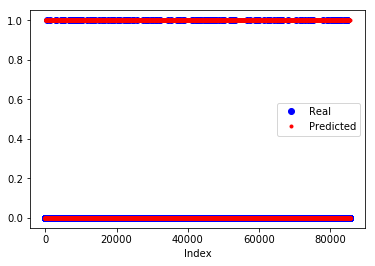

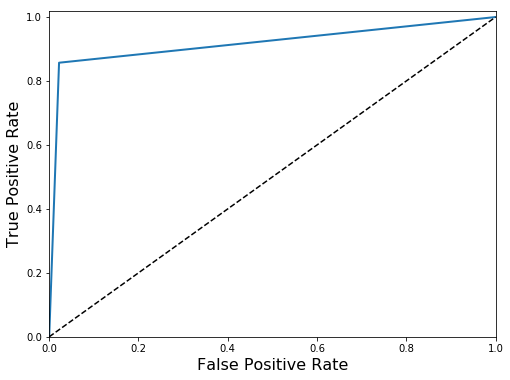

In [16]:
qda = QDA()
qda.train(X_train,Y_train)
D1=[]
D2=[]
D1=qda.use(X_test)
D2 = np.argmax(np.array(D1),axis=0)
errQda = (D2==Y_test)
print("Count of wrong Classified data ",np.size(errQda) - np.count_nonzero(errQda))
qda_stats = allStats(D2, Y_test)

### Apply QDA on Under-Sampled Data

Count of wrong Classified data  25


,0,1
0,141,17
1,8,130


,-,+
-,TN,FN
+,FP,TP


,Stats
Accuracy,0.915541
Precision,0.942029
Recall,0.884354
Specificity,0.946309
F1 Score,13.500000
MCC,18329.993777
ROC_AUC,0.915331


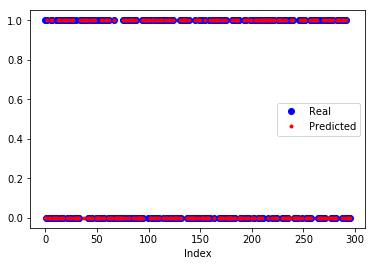

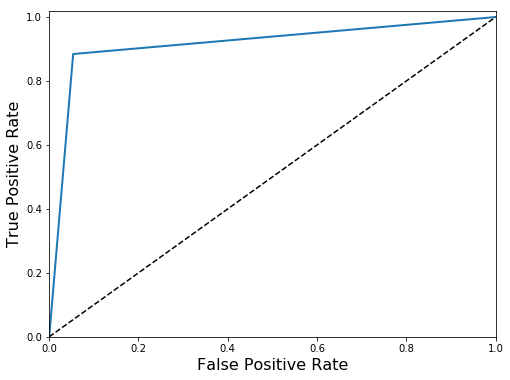

In [17]:
qda_us = QDA()
qda_us.train(X_train_us,Y_train_us)
D1=[]
D2=[]
D1=qda_us.use(X_test_us)
D2 = np.argmax(np.array(D1),axis=0)
# print(D2)
# print(Y_test_us)
# print(np.array(D1))
# D2=np.where(D2==0,-1,1)
errQda = (D2==Y_test_us)
print("Count of wrong Classified data ",np.size(errQda) - np.count_nonzero(errQda))
qda_stats = allStats(D2, Y_test_us)

### QDA using Sklearn Library

Count of wrong Classified data 25


,0,1
0,141,17
1,8,130


,-,+
-,TN,FN
+,FP,TP


,Stats
Accuracy,0.915541
Precision,0.942029
Recall,0.884354
Specificity,0.946309
F1 Score,13.500000
MCC,18329.993777
ROC_AUC,0.915331


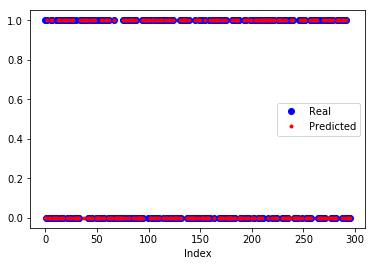

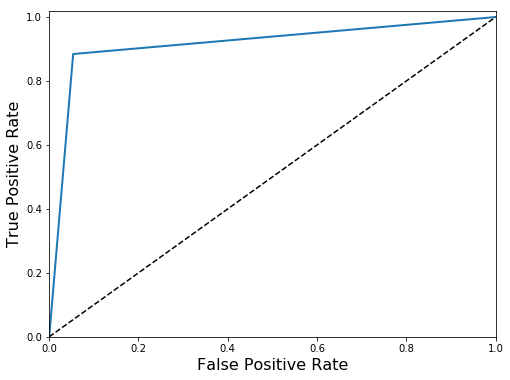

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda1 = QuadraticDiscriminantAnalysis()
qda1.fit(X_train_us, Y_train_us)
dSQda = qda1.predict_proba(X_test_us)
sQD2 = np.argmax(np.array(dSQda),axis=1)
# sQD2=np.where(sQD2==0,-1,1)
serrQda = (sQD2==Y_test_us)
print("Count of wrong Classified data",np.size(serrQda) - np.count_nonzero(serrQda))
qda_sklearn_stats = allStats(sQD2, Y_test_us)

### Apply LDA on Original Data

Count of wrong Classified data 53


,0,1
0,85281,38
1,15,109


,-,+
-,TN,FN
+,FP,TP


,Stats
Accuracy,9.993797e-01
Precision,8.790323e-01
Recall,7.414966e-01
Specificity,9.998241e-01
F1 Score,2.750000e+01
MCC,9.295629e+06
ROC_AUC,8.706604e-01


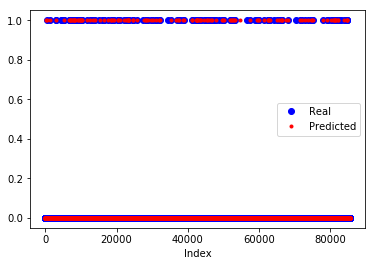

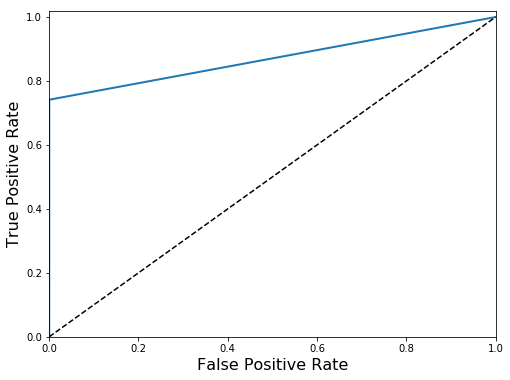

In [19]:
lda = LDA()
lda.train(X_train,Y_train)
LD1=[]
LD2=[]
LD1=lda.use(X_test)
LD2 = np.argmax(np.array(LD1),axis=0)
errLda = (LD2==Y_test)
print("Count of wrong Classified data",np.size(errLda) - np.count_nonzero(errLda))
lda_stats = allStats(LD2, Y_test)

### Apply LDA on Under-Sampled

Count of wrong Classified data 28


,0,1
0,146,25
1,3,122


,-,+
-,TN,FN
+,FP,TP


,Stats
Accuracy,0.905405
Precision,0.976000
Recall,0.829932
Specificity,0.979866
F1 Score,15.000000
MCC,17811.996534
ROC_AUC,0.904899


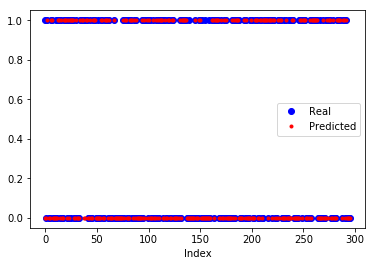

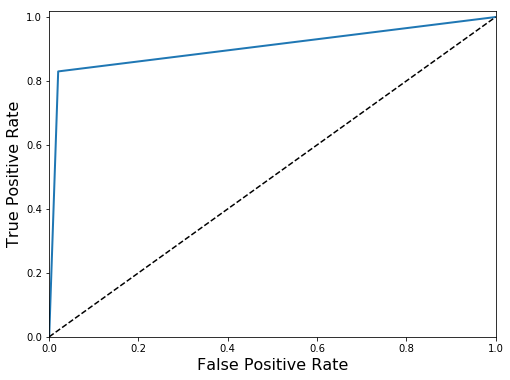

In [20]:
lda_us = LDA()
lda_us.train(X_train_us,Y_train_us)
LD1=[]
LD2=[]
LD1=lda_us.use(X_test_us)
LD2 = np.argmax(np.array(LD1),axis=0)
errLda = (LD2==Y_test_us)
print("Count of wrong Classified data",np.size(errLda) - np.count_nonzero(errLda))
lda_stats = allStats(LD2, Y_test_us)

### LDA using Sklearn Library

Count of wrong Classified data 28


,0,1
0,146,25
1,3,122


,-,+
-,TN,FN
+,FP,TP


,Stats
Accuracy,0.905405
Precision,0.976000
Recall,0.829932
Specificity,0.979866
F1 Score,15.000000
MCC,17811.996534
ROC_AUC,0.904899


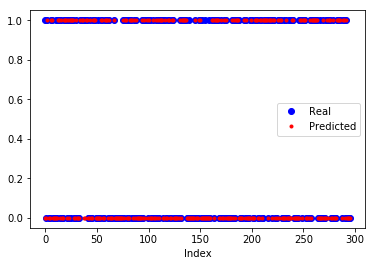

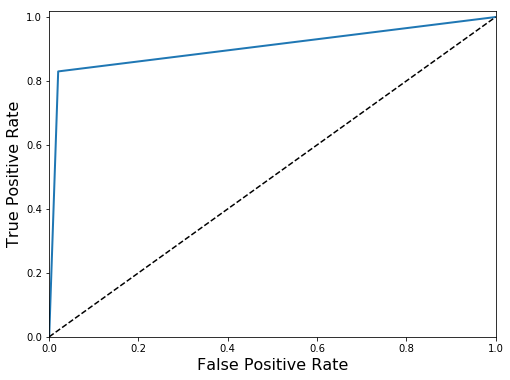

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
slda = LinearDiscriminantAnalysis(n_components=2)
slda.fit(X_train_us, Y_train_us)
dSLda = slda.predict_proba(X_test_us)
sLD2 = np.argmax(np.array(dSLda),axis=1)
# sLD2=np.where(sLD2==0,-1,1)
serrLda = (sLD2==Y_test_us)
print("Count of wrong Classified data",np.size(serrLda) - np.count_nonzero(serrLda))
lda_sklearn_stats = allStats(sLD2, Y_test_us)